In [1]:
import os
import hail as hl
import pyspark
import bokeh
import logging
import random
import pandas as pd
import numpy as np
from scipy import stats
import pickle 
from matplotlib import pyplot as plt
from typing import Any, Counter, List, Optional, Tuple, Union
from hail.plot import show, output_notebook
import matplotlib.pyplot as plt
import seaborn as sns
tmp_dir = "hdfs://spark-master:9820/"
sc = pyspark.SparkContext()
temp_dir = working_dir = os.path.join(os.environ["HAIL_HOME"], "tmp")
hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set("fs.s3a.access.key", "8YY584J59H7Q6AVKHSU8")
hadoop_config.set("fs.s3a.secret.key", "P8vePa7JUvxKXX2me9ti1cGujgYWMoimAwx4mMlM")
hadoop_config.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
hadoop_config.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
hl.init(sc=sc, tmp_dir=tmp_dir, default_reference='GRCh38')
output_notebook()
logging.basicConfig(format="%(levelname)s (%(name)s %(lineno)s): %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

/opt/sanger.ac.uk/hgi/anaconda3/lib/python3.7/site-packages/hail/context.py:71: UserWarning: pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jar
  'pip-installed Hail requires additional configuration options in Spark referring\n'
Running on Apache Spark version 2.4.3
SparkUI available at http://spark-master:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.31-6060f9c971cc
LOGGING: writing to /opt/sanger.ac.uk/hgi/hail/tmp/scripts/sanger_gnomad_hail_qc/notebooks/hail-20200813-1457-0.2.31-6060f9c971cc.log


Loading BokehJS ...

In [2]:
ht_pops=hl.read_table(f"{temp_dir}/ddd-elgh-ukbb/filtering/mt_pops_QC_filters_with_pops_info.ht")
ht_superpops=hl.read_table(f"{temp_dir}/ddd-elgh-ukbb/filtering/mt_superpops_QC_filters_with_superpops_info.ht")

In [7]:
ht_pops.globals.show()

.qc_metrics_stats
"dict<tuple(str), struct{`sample_qc.heterozygosity_rate`: struct{median: float32, mad: float64, lower: float64, upper: float64}, `sample_qc.n_snp`: struct{median: int64, mad: float64, lower: float64, upper: float64}, `sample_qc.r_ti_tv`: struct{median: float64, mad: float64, lower: float64, upper: float64}, `sample_qc.r_insertion_deletion`: struct{median: float64, mad: float64, lower: float64, upper: float64}, `sampleqc.n_insertion`: struct{median: int64, mad: float64, lower: float64, upper: float64}, `sampleqc.n_deletion`: struct{median: int64, mad: float64, lower: float64, upper: float64}, `sample_qc.r_het_hom_var`: struct{median: float64, mad: float64, lower: float64, upper: float64}}>"
"{(""Pakistani""):((2.95e-01,2.45e-02,1.97e-01,3.92e-01),(629,1.93e+01,5.52e..."


In [3]:
ht_pops.flatten().export(f"{temp_dir}/ddd-elgh-ukbb/filtering/mt_pops_QC_filters_with_pops_info_flatten.tsv.bgz", delimiter="\t")

2020-08-13 14:58:22 Hail: INFO: merging 2 files totalling 611.7K...
2020-08-13 14:58:22 Hail: INFO: while writing:
    /opt/sanger.ac.uk/hgi/hail/tmp/ddd-elgh-ukbb/filtering/mt_pops_QC_filters_with_pops_info_flatten.tsv.bgz
  merge time: 113.116ms


In [4]:
df=ht_pops.to_pandas()

In [5]:
df.head()

,s,fail_sample_qc.heterozygosity_rate,fail_sample_qc.n_snp,fail_sample_qc.r_ti_tv,fail_sample_qc.r_insertion_deletion,fail_sampleqc.n_insertion,fail_sampleqc.n_deletion,fail_sample_qc.r_het_hom_var,qc_metrics_filters,pop,cohort
0,EGAN00001006259,False,False,False,None,True,True,False,"[sampleqc.n_deletion, sampleqc.n_insertion]",Pakistani,UK_10K_CHD
1,EGAN00001006260,False,False,False,None,True,True,False,"[sampleqc.n_deletion, sampleqc.n_insertion]",Pakistani,UK_10K_CHD
2,EGAN00001006261,False,False,False,None,True,True,False,"[sampleqc.n_deletion, sampleqc.n_insertion]",oth,UK_10K_CHD
3,EGAN00001006263,False,False,False,None,True,True,False,"[sampleqc.n_deletion, sampleqc.n_insertion]",Pakistani,UK_10K_CHD
4,EGAN00001006264,False,False,False,None,True,True,False,"[sampleqc.n_deletion, sampleqc.n_insertion]",Pakistani,UK_10K_CHD


In [2]:
df_pops=pd.read_csv(f"{temp_dir}/ddd-elgh-ukbb/filtering/mt_pops_QC_filters_with_pops_info.tsv.bgz", compression="gzip",sep="\t")
df_superpops=pd.read_csv(f"{temp_dir}/ddd-elgh-ukbb/filtering/mt_superpops_QC_filters_with_superpops_info.tsv.bgz", compression="gzip", sep="\t")


/opt/sanger.ac.uk/hgi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


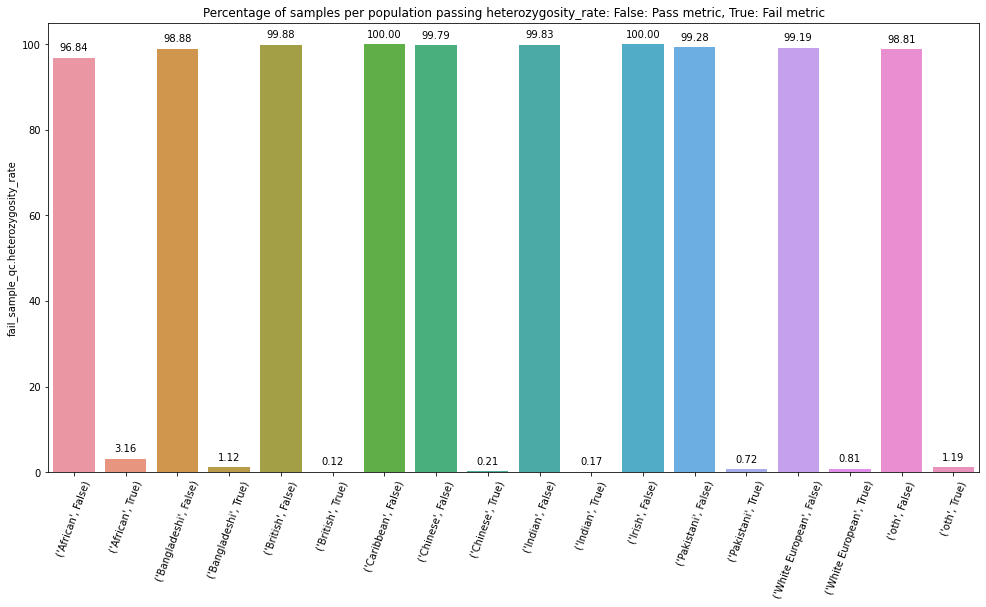

In [4]:
a4_dims = (16.69,8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=70)
ping=sns.barplot(x=(df_pops.groupby("pop")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100).index, y=df_pops.groupby("pop")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100)

for p in ping.patches:
    ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ping.set(title = 'Percentage of samples per population passing heterozygosity_rate: False: Pass metric, True: Fail metric', )
fig = ping.get_figure()

fig.savefig(f"{temp_dir}/ddd-elgh-ukbb/filtering/pops_heterozygosity_rate.png")

In [7]:
print(df_pops.columns)

Index(['s', 'fail_sample_qc.heterozygosity_rate', 'fail_sample_qc.n_snp',
       'fail_sample_qc.r_ti_tv', 'fail_sample_qc.r_insertion_deletion',
       'fail_sampleqc.n_insertion', 'fail_sampleqc.n_deletion',
       'fail_sample_qc.r_het_hom_var', 'qc_metrics_filters', 'pop', 'cohort'],
      dtype='object')


fail_sample_qc.heterozygosity_rate
fail_sample_qc.n_snp
fail_sample_qc.r_ti_tv
fail_sample_qc.r_het_hom_var
qc_metrics_filters


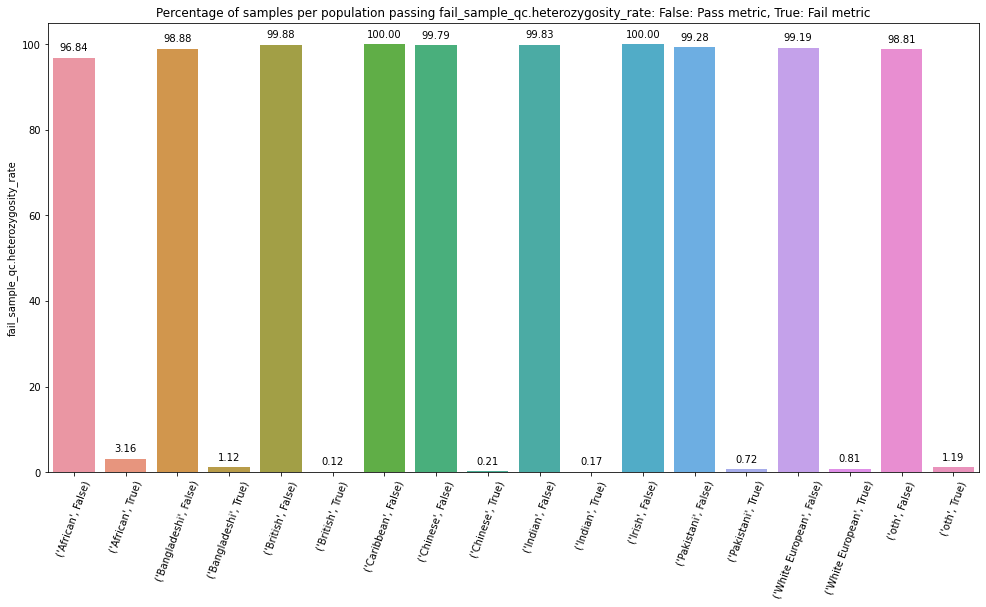

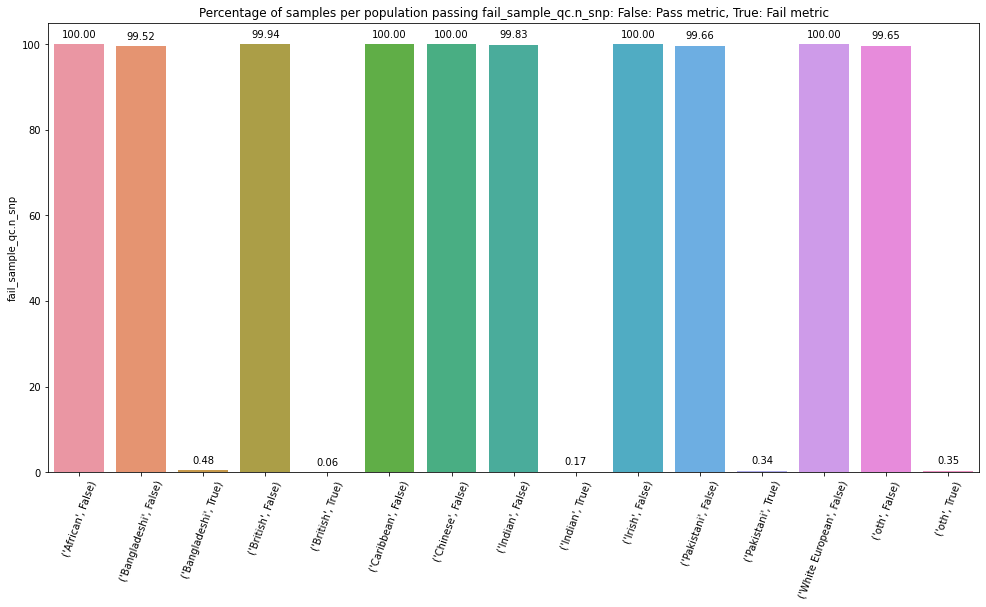

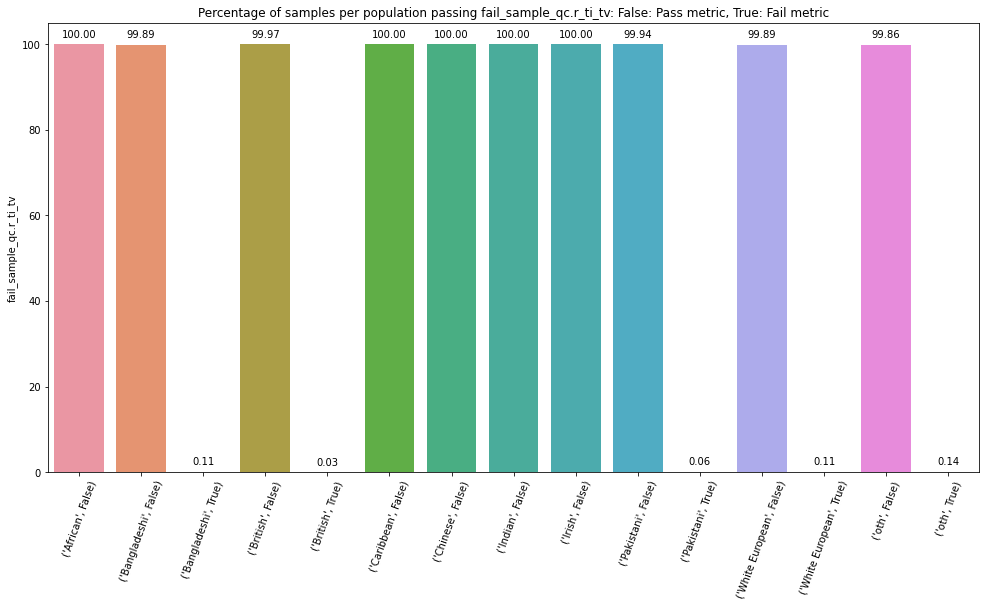

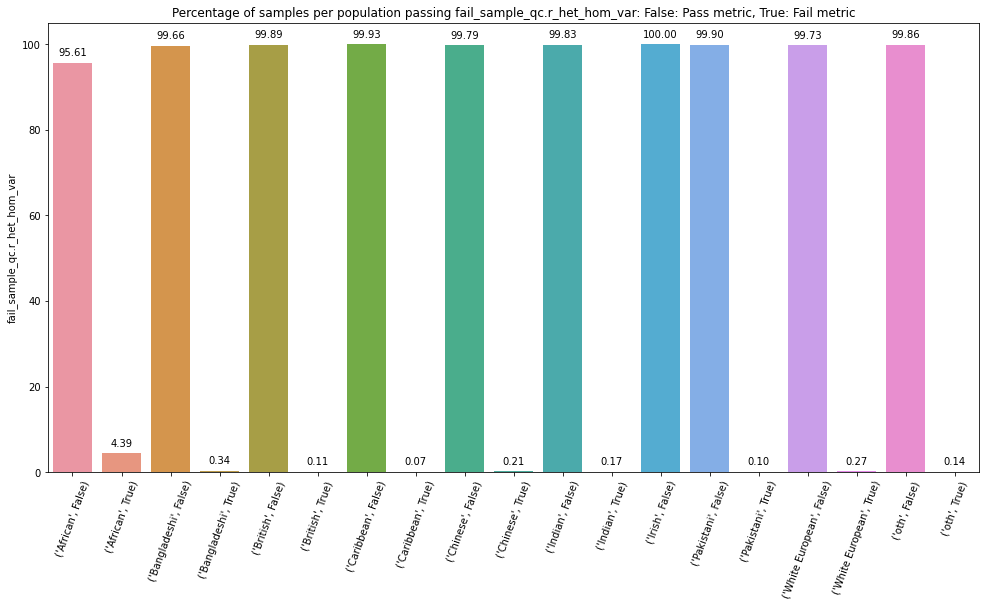

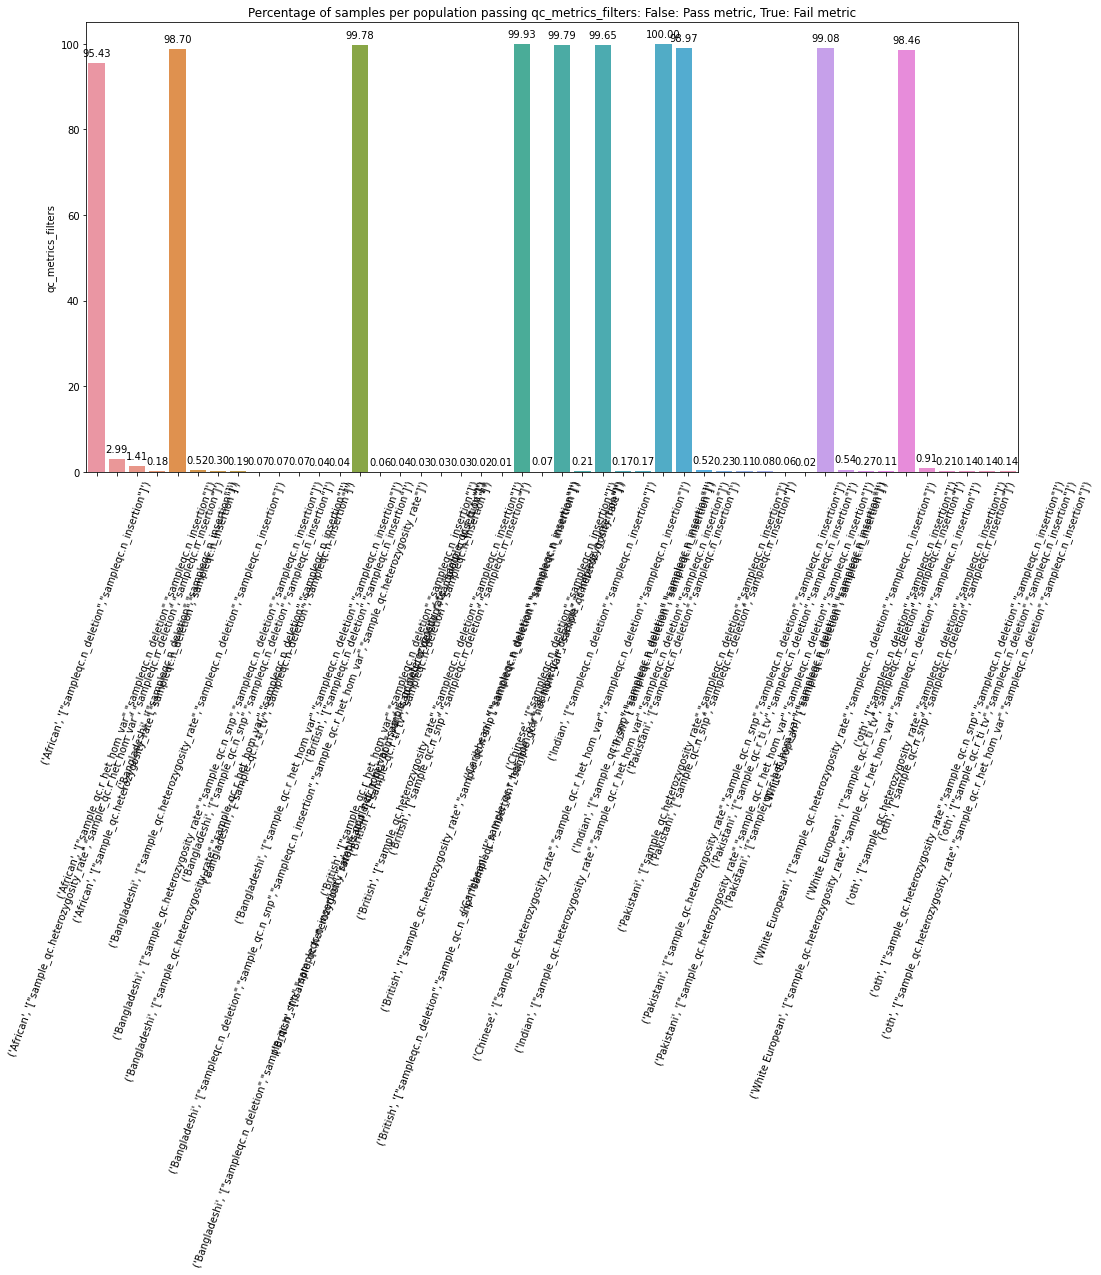

In [16]:
metrics=['fail_sample_qc.heterozygosity_rate', 'fail_sample_qc.n_snp',
       'fail_sample_qc.r_ti_tv',
       'fail_sample_qc.r_het_hom_var', 'qc_metrics_filters']
for metric in metrics:
    print(metric)
    a4_dims = (16.69,8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.xticks(rotation=70)
    ping=sns.barplot(x=(df_pops.groupby("pop")[metric].value_counts(normalize=True)*100).index, y=df_pops.groupby("pop")[metric].value_counts(normalize=True)*100)
    for p in ping.patches:
        ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ping.set(title = f'Percentage of samples per population passing {metric}: False: Pass metric, True: Fail metric', )
    fig = ping.get_figure()

    fig.savefig(f"{temp_dir}/ddd-elgh-ukbb/filtering/pops_{metric}.png")

fail_sample_qc.heterozygosity_rate
fail_sample_qc.n_snp
fail_sample_qc.r_ti_tv
fail_sample_qc.r_het_hom_var
qc_metrics_filters


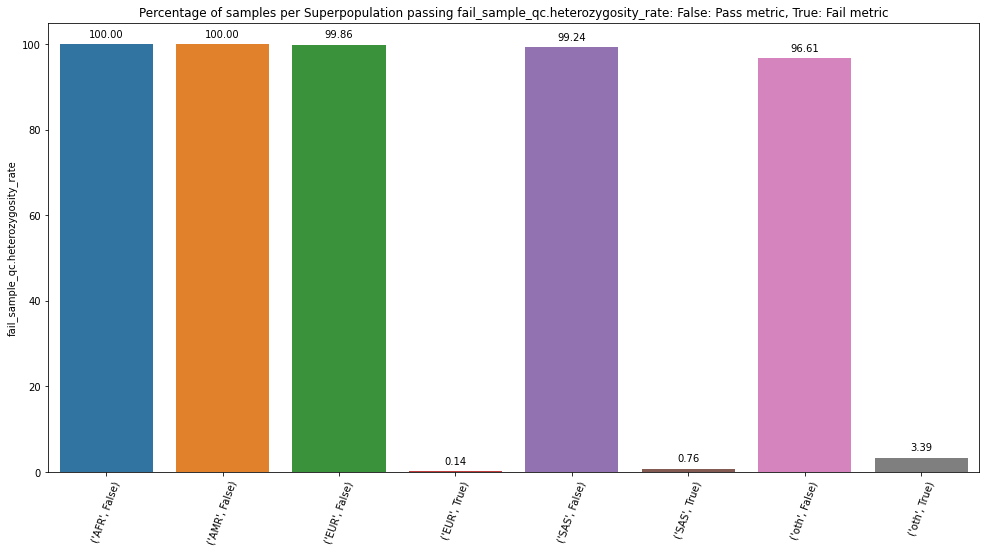

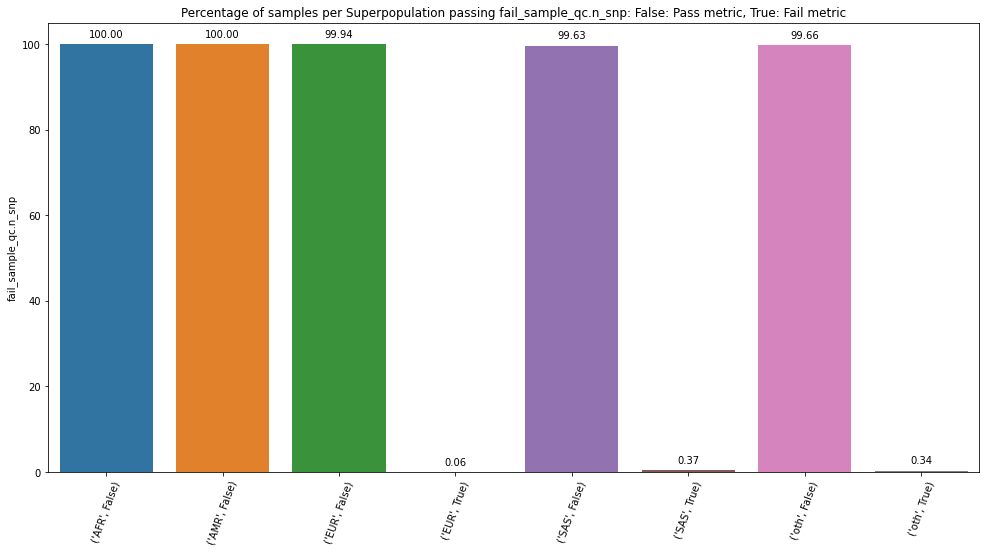

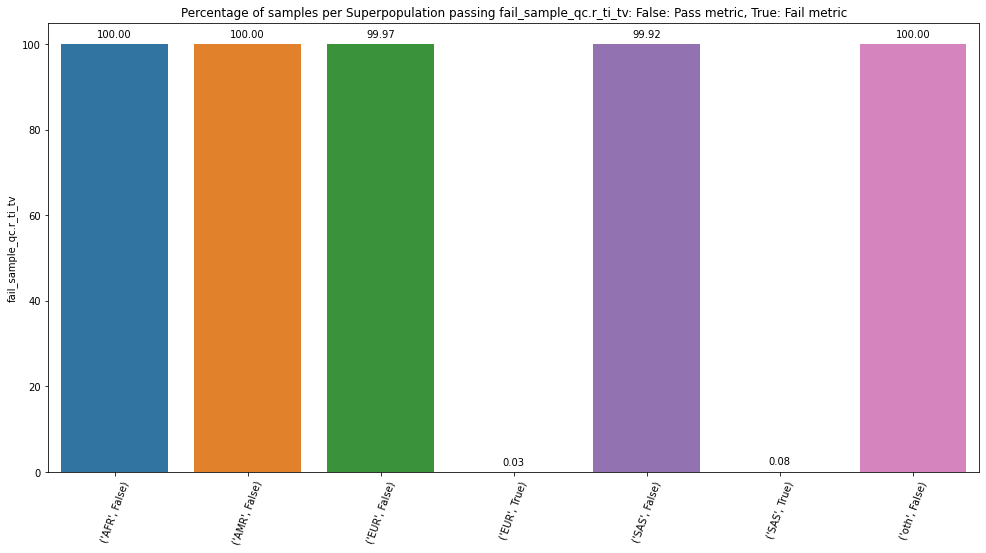

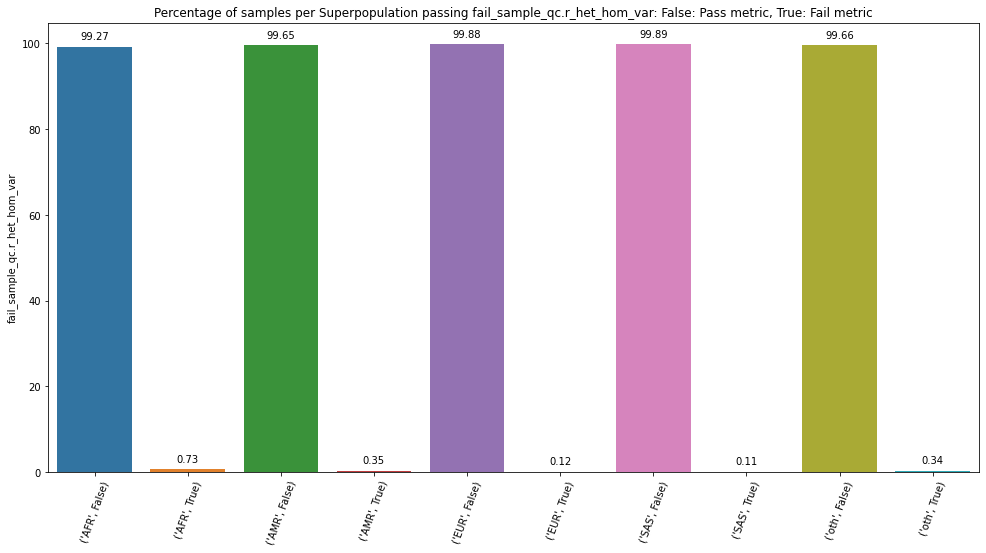

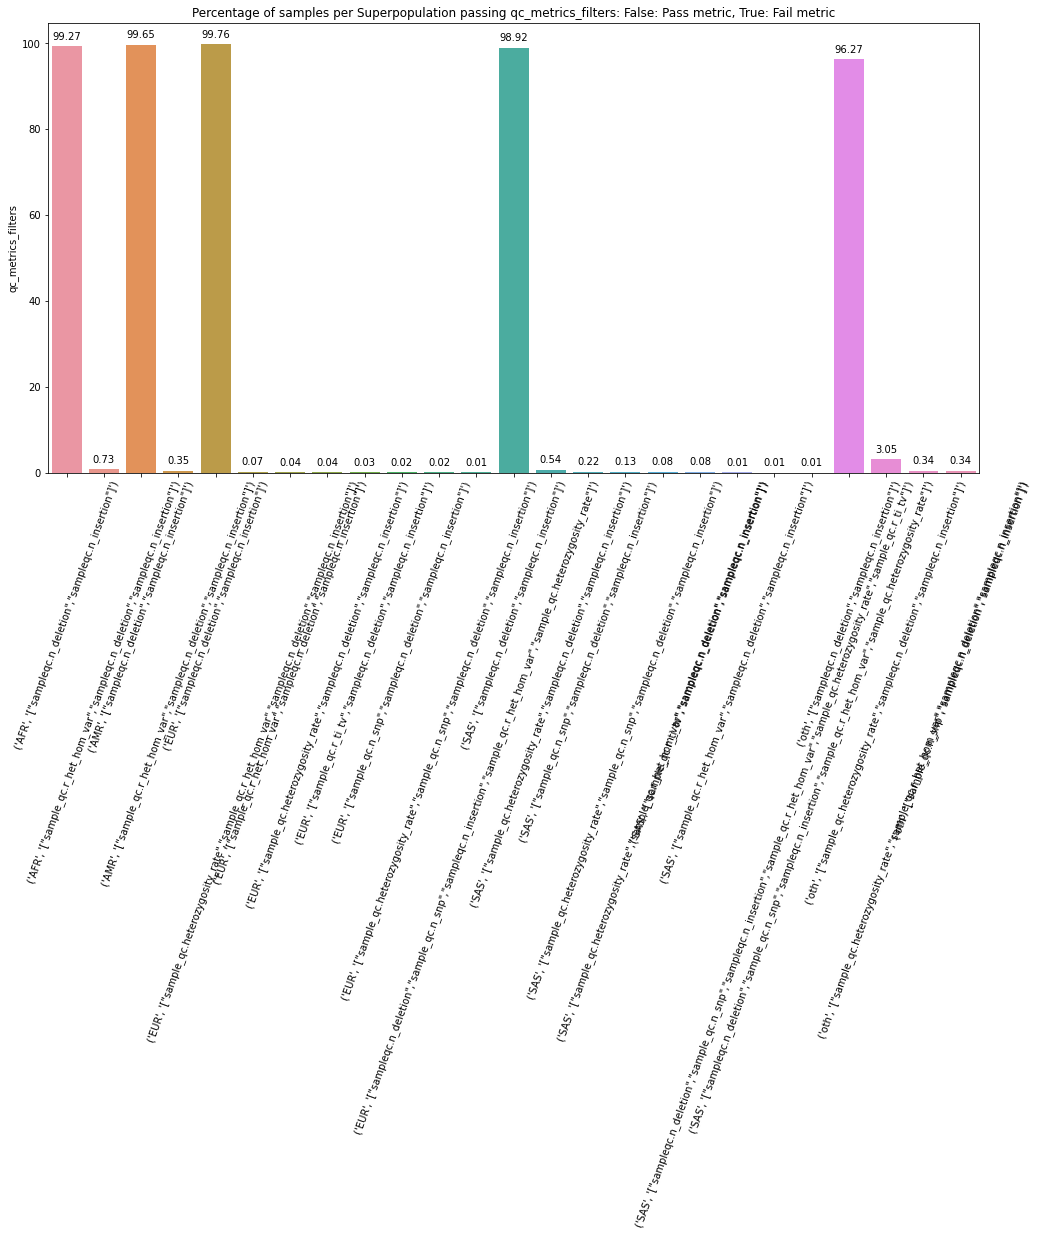

In [18]:
metrics=['fail_sample_qc.heterozygosity_rate', 'fail_sample_qc.n_snp',
       'fail_sample_qc.r_ti_tv',
       'fail_sample_qc.r_het_hom_var', 'qc_metrics_filters']
for metric in metrics:
    print(metric)
    a4_dims = (16.69,8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.xticks(rotation=70)
    ping=sns.barplot(x=(df_superpops.groupby("superpop")[metric].value_counts(normalize=True)*100).index, y=df_superpops.groupby("superpop")[metric].value_counts(normalize=True)*100)
    for p in ping.patches:
        ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    ping.set(title = f'Percentage of samples per Superpopulation passing {metric}: False: Pass metric, True: Fail metric', )
    fig = ping.get_figure()

    fig.savefig(f"{temp_dir}/ddd-elgh-ukbb/filtering/plots/superpops_{metric}.png")

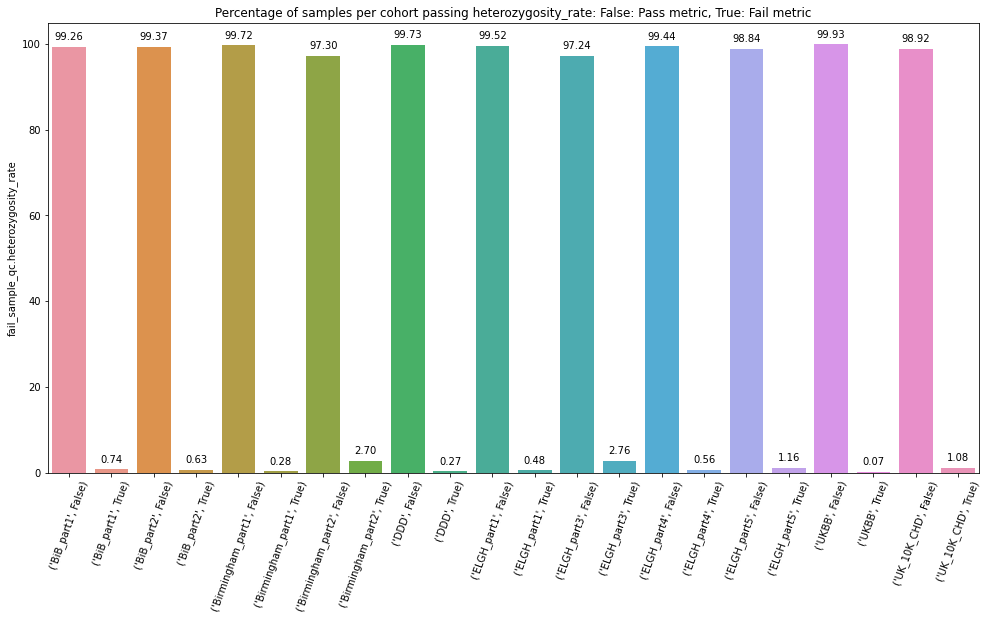

In [20]:
a4_dims = (16.69,8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=70)
ping=sns.barplot(x=(df_pops.groupby("cohort")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100).index, y=df_pops.groupby("cohort")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100)

for p in ping.patches:
    ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ping.set(title = 'Percentage of samples per cohort passing heterozygosity_rate: False: Pass metric, True: Fail metric', )
fig = ping.get_figure()

fig.savefig(f"{temp_dir}/ddd-elgh-ukbb/filtering/plots/pops_cohorts_heterozygosity_rate.png")

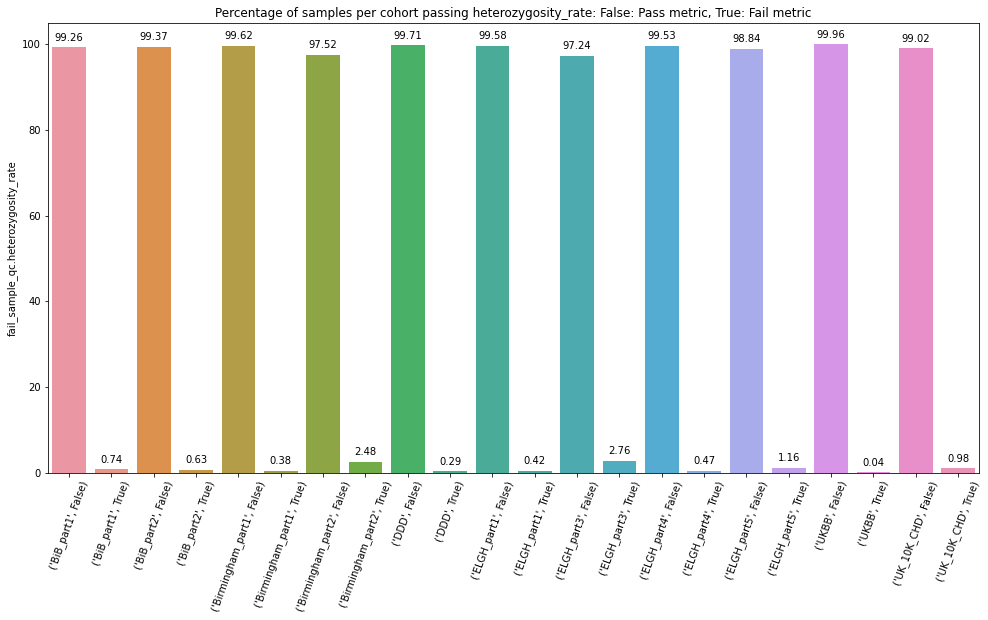

In [21]:
a4_dims = (16.69,8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=70)
ping=sns.barplot(x=(df_superpops.groupby("cohort")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100).index, y=df_superpops.groupby("cohort")["fail_sample_qc.heterozygosity_rate"].value_counts(normalize=True)*100)

for p in ping.patches:
    ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ping.set(title = 'Percentage of samples per cohort passing heterozygosity_rate: False: Pass metric, True: Fail metric', )
fig = ping.get_figure()

fig.savefig(f"{temp_dir}/ddd-elgh-ukbb/filtering/plots/superpops_cohorts_heterozygosity_rate.png")